<a href="https://colab.research.google.com/github/cykrr/ada/blob/master/obst%20xd%20odio%20analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Árbol binario de búsqueda óptimo (Optimal BST)

## Descripción del problema

El problema del árbol binario de búsqueda óptimo consiste en, dado un arreglo de
claves $k$ y un arreglo de probabilidades $p$ (donde a cada elemento $p_n$ le
corresponde un único $k_n$), se busca construir un árbol binario de búsqueda de
forma que este sea óptimo.

Un Optimal BST es aquella permutación de los nodos del arreglo $k$ de forma que
su tiempo de búsqueda promedio para todo nodo de clave $k_n$ es óptimo.

**Entrada**: Un arreglo $k$ con las claves y un arreglo $p$ con las
probabilidades. Ambos de largo $n$.

**Salida**: Costo promedio de búsqueda y un `TreeNode` conteniendo el Optimal
BST.



## Ejemplo

Se tiene un arreglo de claves $k: [1,2,3,4]$ y un arreglo de probabilidades
$p: [40\%,10\%,30\%,20\%]$. Se busca un Optimal BST para dicha entrada.

El costo mínimo para un árbol con dichas
probabilidades posee como mínimo la suma de todas las probabilidades. $.4 + .1 + .3 + .2 = 1$. Esto debido a que cada nodo estará presenta al menos una vez en
el Optimal BST (independiente del nivel).

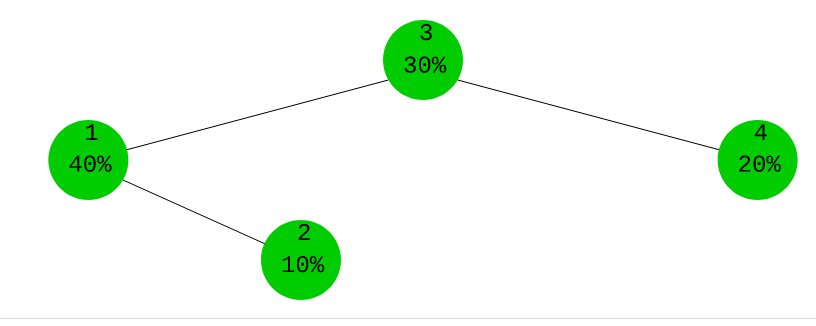

El árbol anterior es óptimo debido a que su promedio del costo de búsqueda por nodo es mínimo. $1 \times .3 + 2 \times (.4 + .2) + 3 \times .2$.

Se obseva que el nodo con mayor probabilidades no siempre será aquel que se
encuentre en la raíz del BST. Esto es debido al orden de las claves. (El elemento de clave $3$ no podría estar a la izquierda del árbol, debido a que $1<3$. Por lo que el elemento añadiría un nivel más al costo de búsqueda. Aumentando su valor.

In [42]:
#@markdown Instalar Cairo (librería de dibujo vectorial)

#@markdown [https://www.cairographics.org](https://www.cairographics.org)
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 12 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:

In [43]:
#@markdown importar librerías necesarias. 

import cairo
from google.colab import files
from IPython.display import SVG, display, Image
from random import randint
from math import sin, cos, pi, inf
from copy import copy, deepcopy

In [44]:
#@markdown ## Clase TreeNode. 

#@markdown Utilizada para facilitar el retorno y la graficación de un (O)BST.

#@markdown  ### Parámetros
#@markdown  `key`: LLave del nodo a almacenar. Valor predeterminado: 0

#@markdown  `freq`: Frequencia de búsqueda del nodo a almacenar.
#@markdown  Valor predeterminado: 0

#@markdown  ### Métodos (públicos)
#@markdown  `append`: Inserta un TreeNode `node` en el árbol

class TreeNode:
    def __init__(self, key = 0, freq = 0):
        self.key = key;
        self.freq = freq;
        
        self.left = None;
        self.right = None;
          
    def __set_right(self, node):
        self.right = node;

    def __set_left(self, node):
        self.left = node;

    def append(self, node):
        if node == None:
            raise Exception("Error. El nodo a agregar es None")
        if node.key == None:
            raise Exception("Error. El nodo a agregar no tiene llave " + 
                            "establecida")
        if node.key >= self.key:
            if self.right == None:
                self.__set_right(node);
            else:
                self.right.append(node);
        elif node.key < self.key:
            if self.left == None:
                self.__set_left(node);
            else:
                self.left.append(node);

In [45]:
#@markdown # Clase `OptimalValue`
#@markdown Utilizada para emparejar un  `TreeNode` con un
#@markdown costo óptimo. Vale decir, una tupla amigable.

#@markdown ## Parámetros

#@markdown `node`: TreeNode a almacenar.

#@markdown `optimal_cost`: Costo mínimo del nodo.



class OptimalValue:
    def __init__(self, node, optimal_cost):
        self.node = node;
        self.optimal_cost = optimal_cost;

In [46]:
#@markdown ## Clase `Vector`
 
#@markdown Vector simple de dos dimensiones.

#@markdown ### Parámetros

#@markdown `x`: Coordenada x.

#@markdown `y`: Coordenada y.

class Vector:
  def __init__(self, x = 0, y = 0):
    self.x = x;
    self.y = y;

  def __str__(self):
    return f"({self.x}, {self.y})"

In [47]:
#@markdown ## Clase `Drawer`

#@markdown Grafica un (sub-)árbol dado una referencia `node` a un TreeNode.

#@markdown ### Parámetros

#@markdown `node`: (sub-)árbol a graficar.

#@markdown `filename`: (opcional) Nombre del archivo temporal

#@markdown `width`: (opcional) Ancho de la imagen de salida

#@markdown `height`: (opcional) Alto de la imagen de salida

#@markdown `radius`: (opcional) Radio de los nodos a dibujar

#@markdown `fontsize`: (opcional) Tamaño de letra de los nodos a dibujar

class Drawer:
  
  def __init__(self, node, filename = "tmp.svg", width = 1280, height = 720,
               radius = 35, fontsize = 16):
    self.__filename = filename
    self.__root = node  
    
    self.__width = width
    self.__height = height

    self.__radius = radius
    self.__fontsize = fontsize

    sep = width // 4

    self.__cursor = Vector(self.__width / 2, 10 + self.__radius)



    

    self.__surface = cairo.SVGSurface(self.__filename, self.__width,
                                      self.__height);

    self.__ctx = cairo.Context(self.__surface);

    self.__ctx.select_font_face("monospace")
    self.__ctx.set_source_rgb(0.0, 0.0, 0.0);
    self.__ctx.set_font_size(fontsize)
    self.__draw(node);
    self.__surface.finish()
    self.__show_svg(filename);
     
  def __update_cursor(self):
    self.__ctx.move_to(self.__cursor.x, self.__cursor.y)

  def __save_cursor(self):
    return deepcopy(self.__cursor)

  def __restore_cursor(self, cursor):
    self.__cursor = deepcopy(cursor)
    self.__update_cursor()

  def __move_radius_cursor(self, angle):
    self.__cursor.x += self.__radius * cos(angle * pi / 180)
    self.__cursor.y += self.__radius * sin(angle * pi / 180)
  
  
  def __draw(self, node, sep = -1):
    if node == None: return;
    if sep == -1: sep = self.__width // 4

    
    # dibujar nodo

    self.__ctx.arc(self.__cursor.x, self.__cursor.y, self.__radius, 0, 2*pi)
    self.__ctx.close_path()
    self.__ctx.set_source_rgb(0.0, 0.8, 0.0);
    self.__ctx.fill()
    self.__ctx.set_source_rgb(0.0, 0.0, 0.0);


    prev = self.__save_cursor() # Guardar posicion del cursor
    # print("prev: ", prev)


    # escribir texto del nodo
    
    e = self.__ctx.text_extents(f"{node.key}")
    self.__cursor.x -= e.width//2
    self.__cursor.y -= 10;
    self.__update_cursor();

    self.__ctx.show_text(f"{node.key}")
    self.__ctx.stroke()

    self.__cursor.x += e.width//2

    self.__cursor.y += e.height*2
    
    e = self.__ctx.text_extents(f"{node.freq}%")
    self.__cursor.x -= e.width//2

    self.__update_cursor();
    self.__ctx.show_text(f"{node.freq}%");
    self.__ctx.stroke();



    if node.left != None:
    # Recuperar cursor inicial
      self.__restore_cursor(prev)
      
    # Recuperar cursor inicial
      self.__move_radius_cursor(150);
      self.__update_cursor();

    # Configurar linea (color y ancho)
      self.__ctx.set_source_rgb(0, 0, 0)
      self.__ctx.set_line_width(0.5)

    # Trazar linea
      self.__ctx.line_to(self.__cursor.x - sep,
                        self.__cursor.y + 2*self.__radius)
      self.__ctx.stroke()

    # Mover cursor a la punta
      self.__cursor.x -= sep
      self.__cursor.y += 2*self.__radius;
    # Dibujar hijo izquierdo
      self.__draw(node.left, sep = sep // 1.68)
   

    


    if node.right != None:
    # Recuperar cursor inicial
      self.__restore_cursor(prev) 

    # Moverse 30 grados (hacia abajo ya que el eje y esta invertido)
      self.__move_radius_cursor(30); 
      self.__update_cursor();

    # Configurar linea
      self.__ctx.set_source_rgb(0, 0, 0)
      self.__ctx.set_line_width(0.5)

    # Trazar linea 
      self.__ctx.line_to(self.__cursor.x + sep,
                        self.__cursor.y + 2*self.__radius)
      self.__ctx.stroke()

    # Mover cursor a la punta
      self.__cursor.x += sep
      self.__cursor.y += 2*self.__radius;
      self.__update_cursor();
      
    # Dibujar hijo derecho
      self.__draw(node.right, sep = sep // 1.5)

  def __show_svg(self, file):
    display(SVG(filename=file))    



    


In [48]:
#@markdown ## Solución Optimal BST recursiva

#@markdown ### Parámetros

#@markdown `k`: (requerido) Arreglo de claves (k)eys `int[]`

#@markdown `d`: (requerido) Arreglo de probabilidades de las claves `k` `float[]`

##@markdown `f`: (requerido) Arreglo de probabilidades de las llaves falsas. `float[]`

#@markdown `l`: Parámetro Interno. Limite izquierdo del sub-arreglo `int`

#@markdown `r`: Parámetro Interno. Limite derecho del sub-arreglo `int`

#@markdown `level`: Parámetro Interno. Nivel de identación de los prints `int`

#@markdown `v`: Verbose? `Boolean`

#@markdown `visualize`: Mostrar el OBST? `Boolean`

#@markdown `count`: Contar llamadas recursivas? `Boolean`

# Imprime cuatro espacios `level veces`

def printlevel(level):
    print("    "*level, end = "")

def optimal_bst_rec(k, d, l = 0, r = -inf, level = 0, v = False, count = False,
                visualize = False):
    if count: global cc;
    # Obtener largo automáticamente
    if r == -inf: r = len(k)-1


    if v: printlevel(level);
    if v: print("OBST:", d[l:r+1], f"l: {l};r: {r}")
    # Casos base
    if l>r:     # No hay elementos en el subarreglo
        if v: printlevel(level);
        if v: print ("no hay elementos.")
        return OptimalValue(node=None,optimal_cost=0)
    if l==r:
        if v: printlevel(level);
        if v: print (f"un elemento. [{d[l]}]")

        return OptimalValue(
                node=TreeNode(key = k[l], freq = d[l]),
                optimal_cost=d[l]
                )

    # Obtener la suma de los elementos
    fsum = sum(d[l:r+1])

    if v: printlevel(level);
    if v: print("suma:", fsum)
     
    # Inicializar el valor mínimo como el máximo
    # valor posible

    Min = inf
    nodo_salida = None

    
    # Uno por uno considerar todos los elementos como raíz y encontrar 
    # el costo del BST recursivamente comparar el costo con el mínimo
    # y actualizar de ser necesario.
    for m in range(l, int(r+1)):
        nodo = TreeNode(key = k[m], freq = d[m])
        if v: printlevel(level)
        if v: print(f"m={m}")
        # Subárbol izq
        if v: printlevel(level)
        if v: print("sub izq")
        
        if count: cc +=1
        ret_left = optimal_bst_rec(k,d, l = l, r = m-1, level = level+1, count = count)
        if ret_left.node: nodo.append(ret_left.node)
        if v: printlevel(level)
        if v: print("fin izq")
        # Subárbol der
        if v: printlevel(level)
        if v: print("sub der")
        if count: cc += 1
        ret_right = optimal_bst_rec(k,d, l = m+1, r = r, level = level+1, count = count)
        if ret_right.node: nodo.append(ret_right.node)
        if v: printlevel(level)
        if v: print("fin der")

        cost = ret_left.optimal_cost + ret_right.optimal_cost

        

        if cost < Min:
            if v: printlevel(level)
            if v: print (cost, "Es menor que", Min)
            Min = cost
            nodo_salida = nodo

    if visualize:
      Drawer(nodo_salida);

    return OptimalValue(node = nodo_salida, optimal_cost=Min + fsum)

OBST: [40, 10, 30, 20] l: 0;r: 3
suma: 100
m=0
sub izq
fin izq
sub der
fin der
90 Es menor que inf
m=1
sub izq
fin izq
sub der
fin der
m=2
sub izq
fin izq
sub der
fin der
80 Es menor que 90
m=3
sub izq
fin izq
sub der
fin der


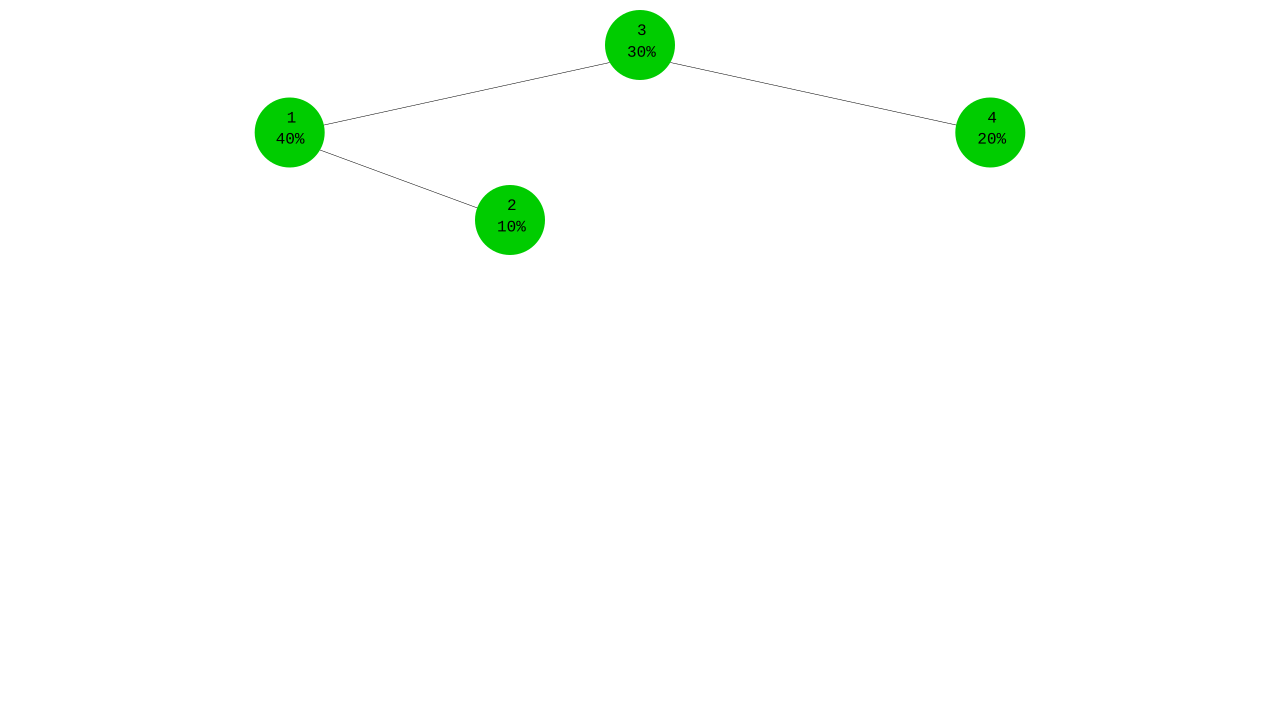

180


In [49]:
# t = TreeNode(key = 0)
optimal_value = optimal_bst_rec([1,2,3,4],[40,10,30, 20], v = True, visualize = True)
print(optimal_value.optimal_cost)

## Descripción de la implementación recursiva

Para esta implementación se calcula el costo del problema en base a los 
subproblemas. Cada (sub-)problema está determinado por los límites del
subarreglo cuyo costo mínimo queremos calcular, recibidos por medio de los parámetros de la función ($l$ y $r$).

Así, se calcula la suma de todas las probabilidades entre $l$ y $r$. Este valor
corresponde al costo mínimo del (sub-)problema. Puesto que cada nodo estará
presente al menos una vez.

Posteriormente se recorren todos los posibles nodos/llaves $k_i$. Para cada nodo $k_i$ se calcula el costo mínimo de ambos hijos. El subproblema izquierdo
$l = l, r =  i -1$ y el subproblema derecho $l = i + 1, r = r$.

Como en toda implementación recursiva se trabaja con un caso base. Concretamente
el caso en el que el sub-árbol no tiene nodos presentes. Este caso se identifica
con $l > r$.

In [50]:
import math
import numpy as np
from numpy import arange

def crear_arbol(root,k, p, i,j):
  if i > j: return None
  if i == j: return TreeNode(key = k[i], freq = p[i])
  n = TreeNode(key = k[int(root[i][j])], freq = p[int(root[i][j])])
  n.left = (crear_arbol(root, k, p, i, int(root[i][j]) - 1));
  n.right = (crear_arbol(root, k, p, int(root[i][j]) + 1, j))
  return n

def optimal_bst_dyn(keys, p, n = -1, v = False, visualize = False, count = False):
  if count: global cc;
  if n == -1: n = len(keys)
  e = np.zeros(shape = (n+1, n+1));
  w = np.zeros(shape = (n+1, n+1));
  root = np.zeros(shape = (n+1, n+1));

  for l in arange(1,n+1): #l: longitud del subárbol
    if v: print(f"Para l={l}")
    for i in arange(n-l+1): #i: Límite izquierdo del subárbol.
      if v: print(f"  i={i}", end = "")
      j = i + l - 1 #j: Límite derecho del subárbol

      if v: print(f"  j={j}")

      e[i][j] = math.inf # Inicializar valor mínimo

      w[i][j] = w[i][j-1] + p[j] # + q[j] # Guardar la suma de %
      if v: print(f"    Se guarda la suma de % {w[i][j]}")
      

      for r in arange(i,j+1):
        if v: print(f"    r={r}. Raíz = {keys[r]}")

        # Calcular costo
        t = (e[i][r-1] if r > i else 0) + (e[r+1][j] if r<j else 0) + w[i][j] 
        
        if count: cc+=1 # Contar la resolución del subproblema
        if v: print(f"    e[{i}][{r}-1]={e[i][r-1]}")
        if v: print(f"    e[{r}+1][{j}]={e[r+1][j]}")
        if t < e[i][j]: # Si es menor, actualizar y guardar nodo
          if v: print(f"{t} es menor que {e[i][j]}")
          e[i][j] = t
          root[i][j] = r
  tree = crear_arbol(root,keys, p, 0, n-1);
  if visualize: Drawer(tree)
  return OptimalValue(optimal_cost = e[0][n-1], node=tree)


optimal_value = optimal_bst_dyn([1,2,3,4],[40,10,30, 20])





## descripcion de la implementacion dinamica

La solucion dinamica recorre todos los subproblemas posibles $n^2$. Resolviendo cada problema de manera lineal. Es decir, buscando la solucion de cada problema revisando una por una las raices posibles. Utiliza memoizacion para obtener los resultados mas rapido.

## Estructura óptima

Se sabe que si un BST es óptimo, luego todos sus sub-árboles $T'$ son óptimos.

Se analizan los sub-árboles para describir la subestructura óptima.

Se considera un sub-árbol $T'$ de un OBST. Para que se cumpla la propiedad de la subestructura óptima es necesario que $T'$  contenga sus llaves en un rango contiguo $k_i..k_j$.

Se elige una llave arbitraria $k_r$ (con $i \leq r \leq j$) cuya clave corresponde a la raíz de algún OBST, conteniendo las claves en dicho intervalo.

En el sub-árbol izquierdo se hallan las llaves $k_i..k_{r-1}$. Mientras que en el sub-árbol derecho se encuentran las llaves $k_{r+1} .. k_j$. 

Para evitar problemas con el cálculo del costo. Se adopta la convención de que un árbol conteniendo las llaves $k_i..k_{i-1}$ no posee claves.

Teorema: El algoritmo obtiene el costo mínimo (y el árbol correspondiente) correctamente.

## Resolución del subproblema

Se define el subproblema de la implementación bottom up como encontrar un BST tal que contenga las llaves en el intervalo $k_i..k_j$.

Se define $e$ como una matriz bidimensional donde se almacenarán las soluciones a los subproblemas. Luego la posición $e[i][j]$ corresponde al costo mínimo de búsqueda para un BST con las llaves $k_i..k_j$. El problema está resuelto cuando se calcula $e[0][n]$. En este punto se presentan dos posibles casos

**Caso 1**: $j < i$. En este caso el BST no tiene elementos (a excepción de una clave falsa, la cual no es considerada). 

**Caso 2**: $j\geq i$. En este caso es necesario definir la raíz arbitraria en el intervalo para recorrer todas las raíces posibles $k_r$ para las cuales se buscará
el costo mínimo de dichos BST.

Es menester considerar que en el caso de procesar un sub-árbol, al costo se le suman todas las probabilidades posibles en sí mismo. (el sub-árbol).

## Función recurrente para solucionar el problema

Para un BST de llaves $k_i..k_j$ se define la suma (acumulada) de las probabilidades como
$$
w(i,j) = \sum_{l=1}^j p_l
$$

Luego, siendo $k_r$ la raíz de un sub-árbol conteniendo las llaves $k_i..k_j$, se tiene que:

$$
e(i, j) = p_r +
e(i, r-1) + w(1, r-1) +
e(r+1, j) + w(r+1,j)
$$

Luego, se elige el árbol óptimo como aquel que provee un costo esperado de búsqueda óptimo (mínimo).

## Prueba de correctitud

Se define $l$ como la longitud del problema a resolver. Para resolver todos los subproblemas se itara desde $l=1$ hasta $l = n$.

**Teorema**: la matriz $e$ contiene el costo mínimo de los $l$ subproblemas.

**Inicio**: Antes de la primea iteración. la matriz de soluciones $e$ no tiene valores guardados.

**Mantenimiento**: Se asume que la matriz $e$ contiene la soluciones de todos los subproblemas anteriores, por lo que el subproblema actual ($l$) es resuelto correctamente.

**Finalización**: Al finalizar la última iteración de $l$, el costo mínimo del problema inicial es calculador correctamente, basándose de sus subproblemas.

## Tiempo de ejecucion de la solucion recursiva

**Teorema**: $T(n) = 3^n$

Es posible demostrar por medio de induccion que  $T(n) = 3^n. Para esto se define un caso base.

**Caso base**: $T(0) = 1$. Siendo la solucion un unico nodo de llave $k_i$ con su costo respectivo $p_i$.

Ocupando la siguiente ecuacion se tiene que:

$$
\begin{aligned}
T(n) &= 2 \cdot \sum_{k = 1} ^ n {T(k-1)} \\
T(n) &= 1 + 2 \cdot \sum_{k=1}^n {3^{k-1}} \\
T(n) &= 1 + 2 \cdot \left ( \cfrac {3^n - 1 } { 3 - 1 } \right ) \\ 
T(n) &= 1 + 3^n - 1 \\
T(n) &= 3^n
\end{aligned}
$$

## Tiempo de ejecucion de la solucion DP

**Teorema**: $T(n) = O(n^3)$.

Observando la implementacion del algoritmo DP es facil intuir que el tiempo de ejecucion es $O(n^3)$ debido a que se basa en 3 ciclos anidados, cuyas iteraciones dependen de $n$.

El objetivo final del algoritmo es calcular $e[0, n]$ mas para esto es necesario calcular todos los subproblemas anteriores. 

La cantidad de subproblemas a resolver es $n^2 / 2$. Este valor corresponde a todas las permutaciones de los subproblemas para cada valor de $i$ y cada valor de $j$ (siendo $i$, $j$ los limites de izquierda y derecha del arreglo). 

La solucion DP se basa en la recursion de los problemas anteriores.

Se tiene un total de $n^2/2$ subproblemas y encontrar cada solucion toma una iteracion de $i$ a $j$ (cuyos valores son directamente dependientes de $n$). 









## Complejidad espacial de las soluciones


La cantidad de subproblemas a resolver es $n^2 / 2$. Este valor corresponde a todas las permutaciones de los subproblemas para cada valor de $i$ y cada valor de $j$ (siendo $i$, $j$ los limites de izquierda y derecha del arreglo). Por lo que la complejidad espacial de la solucion dinamica esta limitada por las matrices. Tenemos tres matrices de tamano nxn por lo que la complejidad espacial de la solucion dinamica es O(n^2).

Para el caso de la solucion recursiva (y tambien la dinamica) se considera como espacio los arreglos de entrada del arreglo como parte de la complejidad espacial. Esto es debido a que a traves de las recursiones, se utilizan los mismos arreglos. Por lo que la complejidad espacial de la solucion recursiva es lineal O(n). 

## Experimentos



La  siguiente pieza de código tiene la funcionalidad de simplificar el funcionamiento de la implementación recursiva para **no generar el árbol correspondiente** puesto que esto toma un porcentaje considerable del tiempo de ejecución, entorpeciendo la visualización del mismo. A pesar de que la implementación dinámica sí genera (y retorna) el árbol correspondiente, esta última supera con creces a la implementación recursiva, como uno podría esperar.

Utilizando la implementación original (presente más arriba en el informe) la generación de un gráfico con los mismos parámetros toma alrededor de una hora.

In [51]:
def optimal_bst_rec2(k, d, l = 0, r = -inf, count = False):
    if count: global cc;
    # Obtener largo automáticamente
    if r == -inf: r = len(k)-1

    if l>r:     
        return OptimalValue(node=None,optimal_cost=0)

    if l==r: return OptimalValue(
                node=TreeNode(key = k[l], freq = d[l]),
                optimal_cost=d[l]
                )
    # Obtener la suma de los elementos
    fsum = sum(d[l:r+1])
    Min = inf
    for m in range(l, int(r+1)):
        if count: cc +=1
        ret_left = optimal_bst_rec2(k,d, l = l, r 
= m-1, count = count)
        if count: cc += 1
        ret_right = optimal_bst_rec2(k,d, l = m+1, r = r, count = count)
        cost = ret_left.optimal_cost + ret_right.optimal_cost
        if cost < Min:
            Min = cost
    return OptimalValue(optimal_cost = Min + fsum, node = None)

### Comparación de los tiempos de ejecución de ambas implementaciones

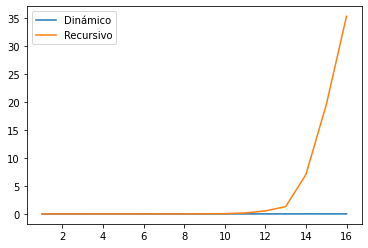

In [52]:
#@markdown Código gráfico 
from timeit import repeat as r
from matplotlib import pyplot as plt

import random
import numpy as np


def random_instance(n):
    keys = sorted(random.sample(range(1, 100), n))
    arr = np.random.random(n*2+1)
    arr /= arr.sum()
    
    p = list(arr[:n]) # Probabilidad de las claves
    return keys, p
    

def load(s):
  return "from __main__ import optimal_bst_" + s

def run(t, k ,p):
  return f"optimal_bst_{t}({k},{p})"

times = 16

x = []; y1 = []; y2 = []
for i in range(1,times+1):
  k, p = random_instance(i)
  t1 = r(setup = load("dyn"), stmt = run("dyn", k, p), repeat = 1, number = 1) 
  t2 = r(setup = load("rec2"), stmt = run("rec2", k, p), repeat = 1, number = 1)
  x.append(i);
  y1.append(t1)
  y2.append(t2)
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(["Dinámico", "Recursivo"])
plt.show()
  


Naturalmente, la implementación dinámica tiene un tiempo mucho menor que la implementación recursiva. Es posible interpretar que el tiempo de ejecución recursivo incrementa exponencialmente, mas no es posible obtener demasiada información acerca de la implementación. Para facilitar la visualización se observarán ambas curvas por separado.

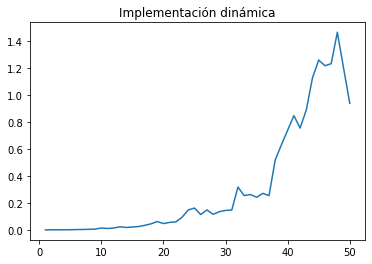

In [53]:
#@markdown Gráfico DP
times = 50

x = []; y1 = []; y2 = []

for i in range(1,times+1):
  k, p = random_instance(i)
  t1 = r(setup = load("dyn"), stmt = run("dyn", k, p), repeat = 1, number = 10) 
  x.append(i);
  y1.append(t1)
plt.plot(x, y1)

plt.title("Implementación dinámica")
plt.show()

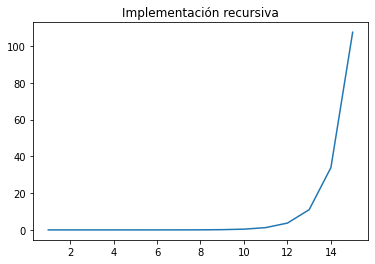

In [54]:
#@markdown Gráfico recursivo
times = 15

x = []; y1 = []; y2 = []

for i in range(1,times+1):
  k, p = random_instance(i)
  t1 = r(setup = load("rec2"), stmt = run("rec2", k, p), repeat = 1, number = 10) 
  x.append(i);
  y1.append(t1)
plt.plot(x, y1)
plt.title("Implementación recursiva")
plt.show()

### Selección fija de raíz como el elemento de mayor probabilidad


In [60]:
import math
from math import inf
def fixed_optimal_bst_rec(k, p, l = 0, r = -100, n = -1, count = False):
    if r == -100: r = n-1
    if count: global cc;
    # Obtener largo automáticamente
    if l > r : return p[l]

    pos = 0; maxp = 0
    for i in range(l, r+1):
      if p[i] > maxp: 
        maxp = p[i];
        pos = i;
    
    # Obtener la suma de los elementos
    fsum = sum(p)
    ret_left = 0
    ret_right = 0
    if pos - 1 > 0:
      ret_left += fixed_optimal_bst_rec(k, p, l = l, r = pos - 1, n = n )
    if pos + 1 < n:
      ret_right += fixed_optimal_bst_rec(k,p, l = pos+1, r = r, n = n)

    cost = ret_left + ret_right

    return cost + fsum


In [59]:
import numpy as np; from numpy import arange
def fixed_optimal_bst_dyn(k, p, n = -1, count = False):
  if count: global cc
  if n == -1: n = len(k) 

  e = np.zeros(shape = (n+1, n+1));
  w = np.zeros(shape = (n+1, n+1));
  root = np.zeros(shape = (n+1, n+1));

  pos = 0; maxp = 0
  pos2 = 0; maxp2 = 0
  for i in range(0, n):
    if p[i] > maxp:
       maxp = p[i];
       pos = i;


  for l in arange(1,n+1): #l: longitud del subárbol
    for i in arange(n-l+1): #i: Límite izquierdo del subárbol.
      j = i + l - 1 #j: Límite derecho del subárbol

      w[i][j] = w[i][j-1] + p[j] 

      for k in range(i, j):
        if p[k] > maxp2:
         maxp2 = p[i];
         pos2 = i;

      e[i][j] = e[i][pos2 - 1] + e[pos2 + 1][j] + w[i][j]

  return e[0][n-1]


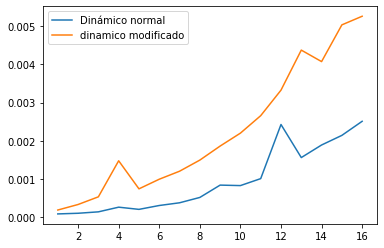

In [57]:
times = 16

x = []; y1 = []; y2 = []
for i in range(1,times+1):
  k, p = random_instance(i)
  t1 = r(setup = load("dyn"), stmt = run("dyn", k, p), repeat = 1, number = 1) 
  t2 = r(setup = "from __main__ import fixed_optimal_bst_dyn as optimal_bst_dyn", stmt = run("dyn", k, p), repeat = 1, number = 10)
  x.append(i);
  y1.append(t1)
  y2.append(t2)
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(["Dinámico normal", "dinamico modificado"])
plt.show()
  

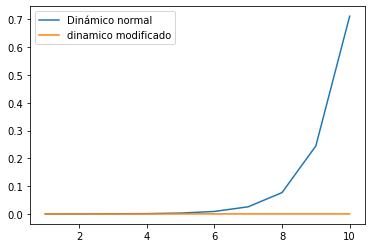

In [61]:
times = 10

x = []; y1 = []; y2 = []
for i in range(1,times+1):
  k, p = random_instance(i)
  t1 = r(setup = load("rec"), stmt = run("rec", k, p), repeat = 1, number = 10) 
  t2 = r(setup = "from __main__ import fixed_optimal_bst_rec as optimal_bst_rec", stmt = run("rec", k, p), repeat = 1, number = 10)
  x.append(i);
  y1.append(t1)
  y2.append(t2)
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(["recursivo normal", "recursivo modificado"])
plt.show()
  

Es posible observar que la modificacion favorece al tiempo en la solucion recursiva. Mas no en la dinamica. Esto es debido a que tiene una complejidad lineal en la nueva recursiva y una cuadratica en la nueva dinamica. Por lo que los resultados son los esperados. Si bien en una de estas se favorece el tiempo. El costo del arbol sera mayor en la mayoria de los casos puesto que no siempre se estara trabajando con el arbol optimo.

Considero que es mejor trabajar la solucion dinamica para casos generales puesto que presenta un tiempo de ejecucion menor, ademas de permitir la optimizacion de Knuth. La cual lleva el tiempo de ejecucion a $n^2$.